<a href="https://colab.research.google.com/github/bryan255/cs624_assignment2/blob/main/CS624_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS624 Machine Learning Model Pipeline

*Presented by:*


*   Bryan Kors | bkors001@odu.edu | [bryan255.github.io](https://bryan255.github.io/#aboutme)
*   Dipendra Thapa Magar | dthap001@odu.edu | [dipendrathapamagar.github.io](https://dipendrathapamagar.github.io)



## Introduction

This is a machine learning pipeline predicting a death event based on 299 records with 13 clinical features. The dataset is from the UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records


Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- creatinine phosphokinase  (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction  (percentage)
- high blood pressure: if the patient has hypertension (boolean)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient died during the follow-up period (boolean)

The pipeline includes the following:

- Importing and cleaning the dataset
  - The dataset is relatively clean, does not include NaNs, and already has binary features encoded
- Data analysis and visualization of the features
  - Features include continuous and binary variables
- Data cleaning & pre-processing
  - Features are not similar measures and will need to be standardized
- Feature Engineering:
  - PCA
  - SMOTE
- Classifier Algorithms (including KFold Cross Validation & hyperparameter tuning):
  - Logistic Regression
  - Random Forest
  - XGBoost
- Summary & Conclusion

## Data Importing & Cleaning

In [1]:
# importing needed modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Data loading

path = r'https://raw.githubusercontent.com/bryan255/cs624_assignment2/main/heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(path)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
# Data cleaning
## check for null values and values < 0 dataframe formatting

null_counts = df.isna().sum().sum()
less_than_zero_counts = df[df < 0].sum().sum()

print(f'Total Null Values: {null_counts}')
print(f'Total Values < 0: {int(less_than_zero_counts)}')

Total Null Values: 0
Total Values < 0: 0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
# identify variables in dataset

y = df.DEATH_EVENT
binary_vars = df.iloc[:, [1, 3, 5, 9, 10]]
cont_vars = df.iloc[:, [0, 2, 4, 6, 7, 8, 11]]
print(f'Target variable:\n{y.head()}\n')
print(f'Binary variables:\n{binary_vars.head()}\n')
print(f'Continuous variables:\n{cont_vars.head()}\n\n')

x = pd.merge(cont_vars, binary_vars, how='outer', left_index=True, right_index=True)
print(f'Independent Variables:\n{x.head()}')

Target variable:
0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64

Binary variables:
   anaemia  diabetes  high_blood_pressure  sex  smoking
0        0         0                    1    1        0
1        0         0                    0    1        0
2        0         0                    0    1        1
3        1         0                    0    1        0
4        1         1                    0    0        0

Continuous variables:
    age  creatinine_phosphokinase  ejection_fraction  platelets  \
0  75.0                       582                 20  265000.00   
1  55.0                      7861                 38  263358.03   
2  65.0                       146                 20  162000.00   
3  50.0                       111                 20  210000.00   
4  65.0                       160                 20  327000.00   

   serum_creatinine  serum_sodium  time  
0               1.9           130     4  
1               1.1           136     6  
2        

## Initial Data Analysis & Data Visualization

### Summary Statistics

In [8]:
# data frame summary statistics

summary_df = df.describe().T
summary_df

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


With the exception of SEX, the binary variables has 0 for no and 1 for yes. In regard to SEX, 0 is Female and 1 is Male.

Additionally, our target variable is DEATH_EVENT which follows the same convention as the binary variables: 0 for no and 1 for yes.

### Feature & Target Identification

In [9]:
print(f'The target variable is {y.name}.')

print('\nBelow are the binary features:')
for f in binary_vars.columns:
  print(f'{f}')

print('\nBelow are the continuous features:')
for f in cont_vars.columns:
  print(f'{f}')

The target variable is DEATH_EVENT.

Below are the binary features:
anaemia
diabetes
high_blood_pressure
sex
smoking

Below are the continuous features:
age
creatinine_phosphokinase
ejection_fraction
platelets
serum_creatinine
serum_sodium
time


### Target & Binary Features Analysis


      Class balances:
      Class 0: 203 (67.89%)
      Class 1: 96 (32.11%)



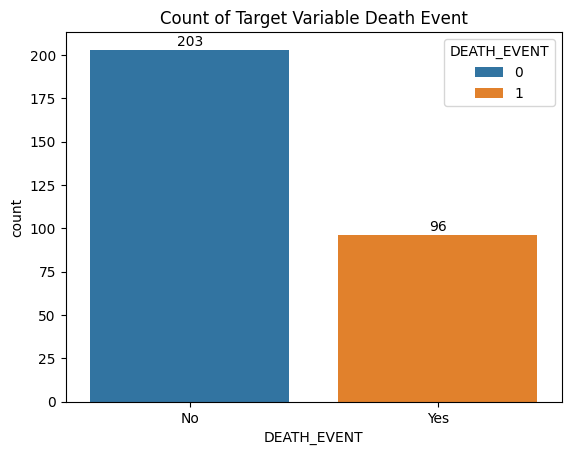

In [10]:
# target feature distribution

sns.countplot(x=y, hue=y)
plt.title('Count of Target Variable Death Event')
plt.xticks(ticks=plt.gca().get_xticks(), labels=['No', 'Yes'])

target_counts = y.value_counts()
print(f'''
      Class balances:
      Class 0: {target_counts[0]} ({target_counts[0] / target_counts.sum() * 100:.2f}%)
      Class 1: {target_counts[1]} ({target_counts[1] / target_counts.sum() * 100:.2f}%)
''')

c = plt.gca().containers
for i in range(len(c)):
  plt.bar_label(c[i], fontsize=10, padding=1)

The target variable shows highly imbalanced; nearly 70/30 split between classifications. We will use SMOTE to perform class balancing.

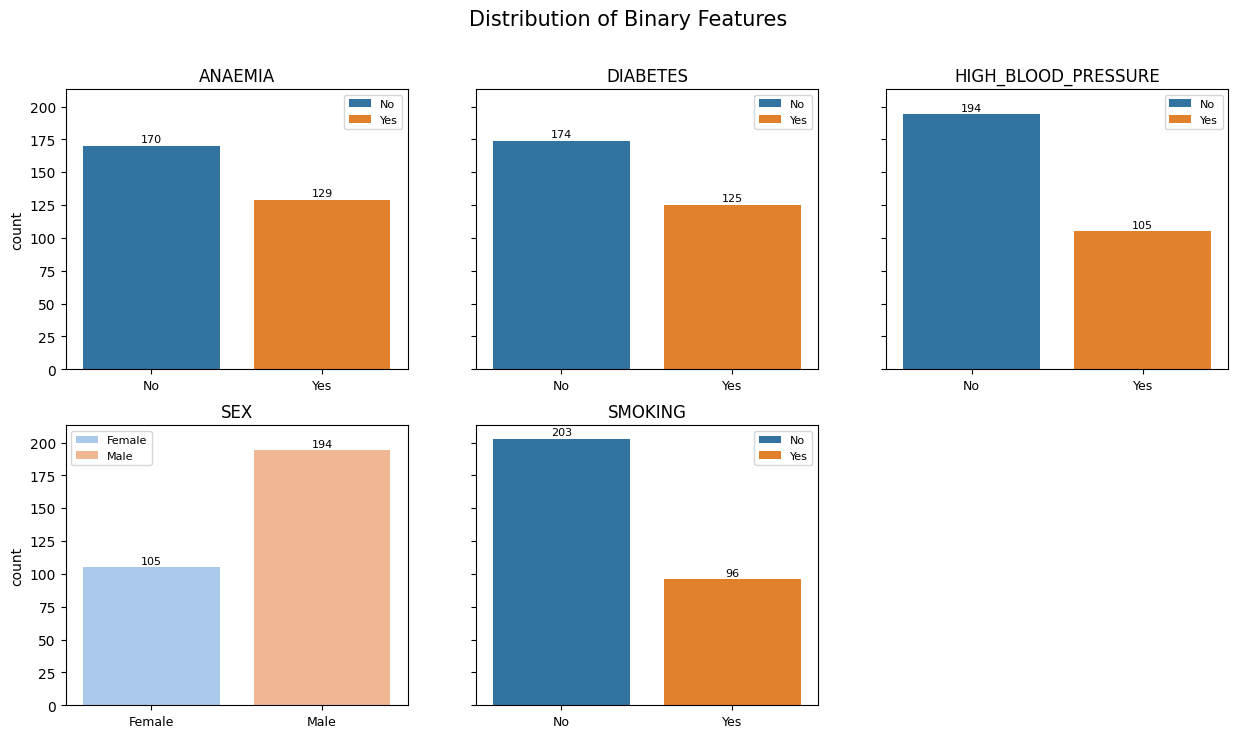

In [11]:
# binary features distribution

fig, ax = plt.subplot_mosaic(mosaic=[[0, 1, 2], [3, 4, '.']], figsize=(15, 8), sharey=True)

columns = binary_vars.columns

for i in range(len(columns)):
  if i == 3:
    sns.countplot(df, x=columns[i], hue=columns[i], ax=ax[i], palette='pastel', legend=True)
    ax[i].set_xticks([0,1], ['Female', 'Male'], fontsize=9)
    ax[i].legend(labels=['Female', 'Male'], fontsize=8)
  else:
    sns.countplot(df, x=columns[i], hue=columns[i], ax=ax[i], legend=True)
    ax[i].set_xticks([0,1], ['No','Yes'], fontsize=9)
    ax[i].legend(labels=['No', 'Yes'], fontsize=8)
  ax[i].set_xlabel('')
  ax[i].set_title(columns[i].upper())
  for c in ax[i].containers:
    ax[i].bar_label(c, fontsize=8, padding=1)

plt.suptitle('Distribution of Binary Features', fontsize=15)
plt.show()

### Continuous Features Analysis

In [12]:
# summary statistics of continuous variables

round(cont_vars.describe().loc[['mean', 'min', '25%', '50%', '75%', 'max'],:].T, 2)

,mean,min,25%,50%,75%,max
age,60.83,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,581.84,23.0,116.5,250.0,582.0,7861.0
ejection_fraction,38.08,14.0,30.0,38.0,45.0,80.0
platelets,263358.03,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,1.39,0.5,0.9,1.1,1.4,9.4
serum_sodium,136.63,113.0,134.0,137.0,140.0,148.0
time,130.26,4.0,73.0,115.0,203.0,285.0


Based on the mean and median, serum_creatinine is right skewed and creatinine_phosphokinase is significantly right skewed. This is also supported in the visuals below.

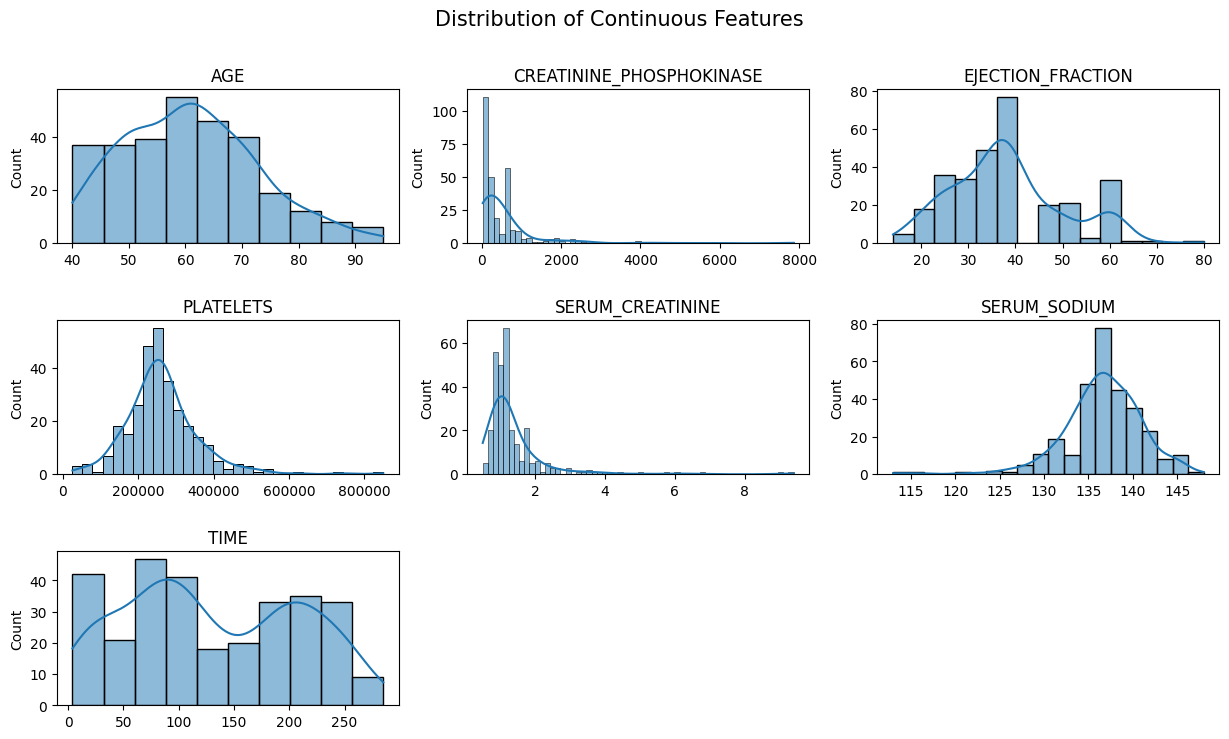

In [13]:
# continuous features histograms

fig, ax = plt.subplot_mosaic(mosaic=[[0, 1, 2], [3, 4, 5], [6, '.', '.']], figsize=(15, 8))

cols = cont_vars.columns

for i in range(7):
  sns.histplot(cont_vars, x=cols[i], ax=ax[i], legend=False, kde=True)
  ax[i].set_title(cols[i].upper())
  ax[i].set_xlabel('')

plt.subplots_adjust(hspace=.5)
plt.suptitle('Distribution of Continuous Features', fontsize=15)
plt.show()

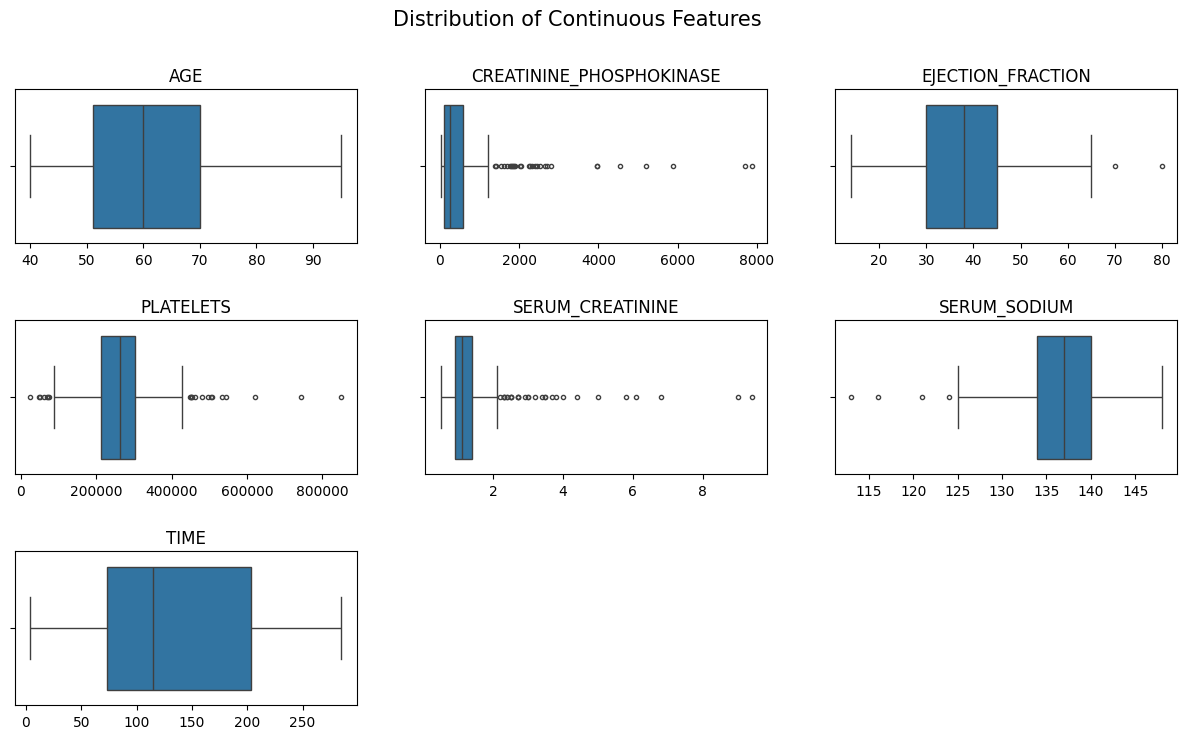

In [14]:
# boxplots of continuous features

fig, ax = plt.subplot_mosaic(mosaic=[[0, 1, 2], [3, 4, 5], [6, '.', '.']], figsize=(15, 8))

for i in range(7):
  sns.boxplot(cont_vars, x=cols[i], ax=ax[i], legend=False, flierprops={'marker' : '.'})
  ax[i].set_title(cols[i].upper())
  ax[i].set_xlabel('')

plt.subplots_adjust(hspace=.5)
plt.suptitle('Distribution of Continuous Features', fontsize=15)
plt.show()

The visuals show significant differences in values for each measure. For example, platelets have measures in the hundreds of thousands while serum creatinine have values < 10.

We will use StandardScaler to scale all continuous variables before training/testing.

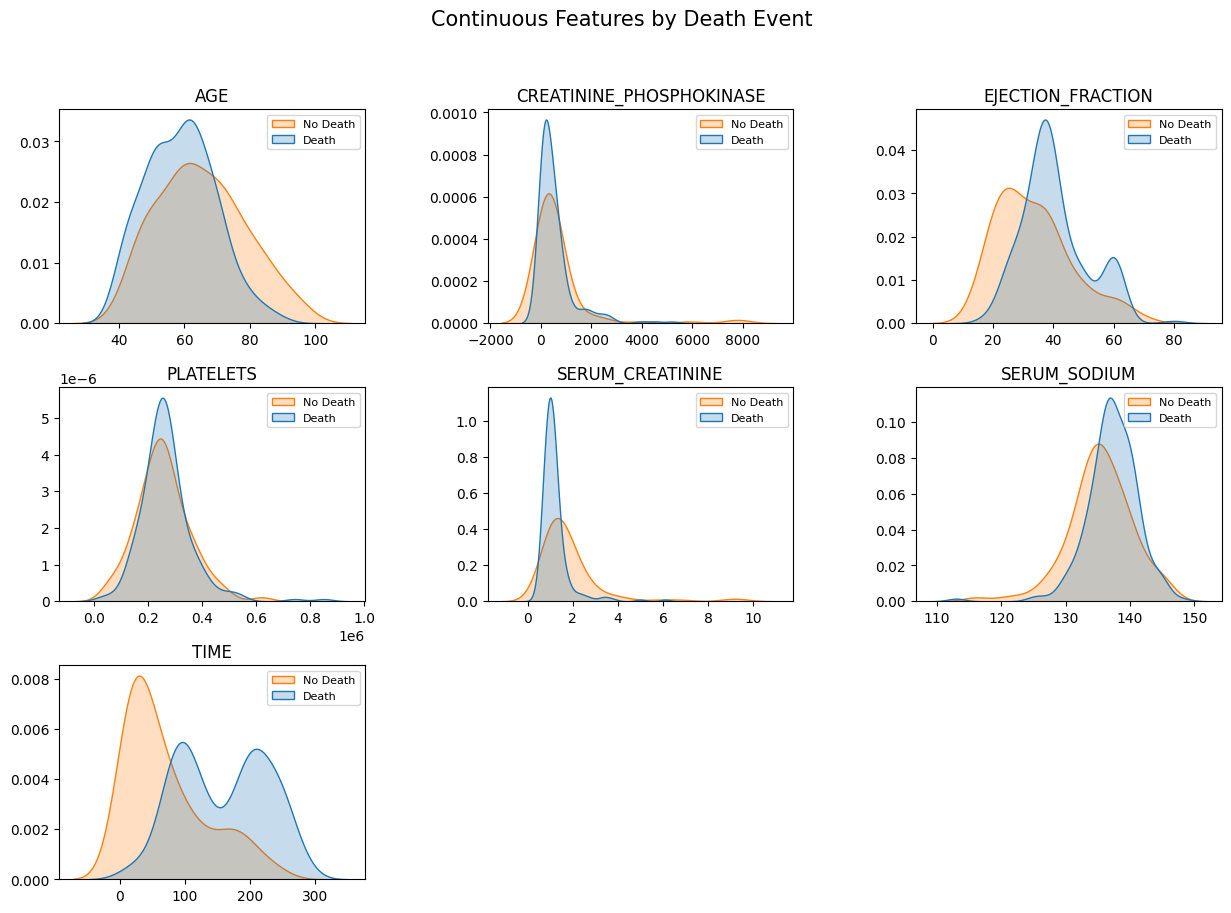

In [26]:
# histplot of continuous variables by target variable

fig, ax = plt.subplot_mosaic(mosaic=[[0, 1, 2], [3, 4, 5], [6, '.', '.']], figsize=(15, 10))

for i in range(7):
  # sns.boxplot(df, x='DEATH_EVENT', y=cols[i], ax=ax[i], legend=True)
  sns.kdeplot(df, x=cols[i], ax=ax[i], hue='DEATH_EVENT', fill=True, common_norm=False, legend=True)
  ax[i].set_title(cols[i].upper())
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].get_legend().set_title('')
  ax[i].legend(labels=['No Death', 'Death'], fontsize=8)
  # ax[i].set_xticks(ax[i].get_xticks(), ['No Death', 'Death'])
  # ax[i].tick_params('both', labelsize=8)

plt.subplots_adjust(hspace=.3, wspace=.4)
plt.suptitle('Continuous Features by Death Event', fontsize=15)
plt.show()

Reviewing each continuous variable by death event, there appears the platelets and creatinine phosphokinase appears to be consistent across both conditions given the IQR overlap.

We can test removing these two variables during training to measure the impact.

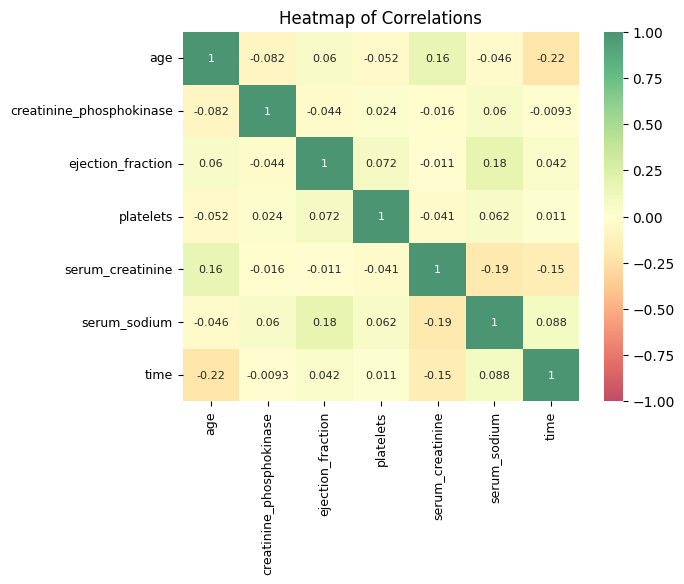

In [ ]:
sns.heatmap(cont_vars.corr(),
            annot=True,
            cmap='RdYlGn',
            vmin=-1,
            vmax=1,
            annot_kws={'fontsize' : 8},
            alpha=.7)
plt.tick_params(axis='both', labelsize=9)
plt.title('Heatmap of Correlations')
plt.show()

The heatmap does not show correlations among the continuous variables.

## Data Cleaning & Pre-processing

### Scaling Continuous Variables

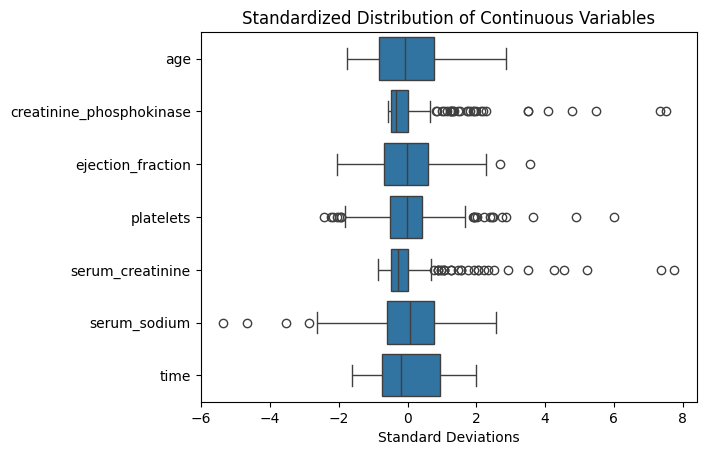

In [ ]:
# scaling continuous variables and replotting boxplot

scaler = StandardScaler().fit(cont_vars)
scaled_df = pd.DataFrame(scaler.transform(cont_vars), columns=cont_vars.columns)
melted_df = pd.melt(scaled_df)

sns.boxplot(melted_df, y='variable', x='value')
plt.xlabel('Standard Deviations')
plt.ylabel('')
plt.title('Standardized Distribution of Continuous Variables')
plt.show()

In [ ]:
# merge scaled continuous variables with binary variables

scaled_x = pd.merge(scaled_df, binary_vars, how='outer', left_index=True, right_index=True)
scaled_x.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,0,1,1,0
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1,0
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1,0
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,1,0,0,0


### Outlier Analysis

In [ ]:
# count of outliers in dataset

from matplotlib.cbook import boxplot_stats

print('Below is a count of outliers in each continous variable:\n')

idx_list = np.array([])

for f in cont_vars.columns:
  outliers = boxplot_stats(df[f])[0]['fliers']
  outliers_count = len(outliers)
  temp_list = list(df[df[f].isin(outliers)].index)
  idx_list = np.concatenate([idx_list, temp_list])
  print(f'{f}: {outliers_count} outliers ({(outliers_count/299) * 100:.2f}%)')

idx_list = list(set(idx_list))
print(f'\nThere are {len(idx_list)} ({len(idx_list)/df.shape[0]:.2f}%) records containing at least one outlier across all continous variables.')

Below is a count of outliers in each continous variable:

age: 0 outliers (0.00%)
creatinine_phosphokinase: 29 outliers (9.70%)
ejection_fraction: 2 outliers (0.67%)
platelets: 21 outliers (7.02%)
serum_creatinine: 29 outliers (9.70%)
serum_sodium: 4 outliers (1.34%)
time: 0 outliers (0.00%)

There are 75 (0.25%) records containing at least one outlier across all continous variables.


serum_creatinine and creatinine_phosphokinase have the largest number of outliers. Most of these outliers are within roughly two standard deviations of the mean.

Given the outliers are not negative, do not appear to be errors in data entry, and are minimal, we will not remove the outliers.

## Feature Engineering

### Class balancing with SMOTE

In [ ]:
# perform class balancing of DEATH_EVENT

pre_class, pre_count = np.unique(y, return_counts=True)
pre_dict = dict(zip(pre_class, pre_count))

print('Class balances before SMOTE:')
for key, value in pre_dict.items():
  print(f'Class {key}: {value}')

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

post_class, post_count = np.unique(y_smote, return_counts=True)
post_dict = dict(zip(post_class, post_count))
print('\nClass balance after SMOTE:')
for key, item in post_dict.items():
  print(f'Class {key}: {item}')

Class balances before SMOTE:
Class 0: 203
Class 1: 96

Class balance after SMOTE:
Class 0: 150
Class 1: 150


### PCA Analysis

In [ ]:
# PCA

pca = PCA().fit(scaled_x)
x_pca = pca.transform(scaled_x)

pca_df = {'Component' : np.arange(1, pca.n_components_ + 1),
          'Explained Ratio' : pca.explained_variance_ratio_,
          'Cumulative Ratio' : np.cumsum(pca.explained_variance_ratio_)}

pca_df = pd.DataFrame(pca_df)

print(pca_df)

    Component  Explained Ratio  Cumulative Ratio
0           1         0.181788          0.181788
1           2         0.145969          0.327757
2           3         0.126734          0.454490
3           4         0.119750          0.574240
4           5         0.110015          0.684255
5           6         0.091303          0.775558
6           7         0.089876          0.865434
7           8         0.041813          0.907246
8           9         0.027638          0.934885
9          10         0.027055          0.961940
10         11         0.023578          0.985518
11         12         0.014482          1.000000


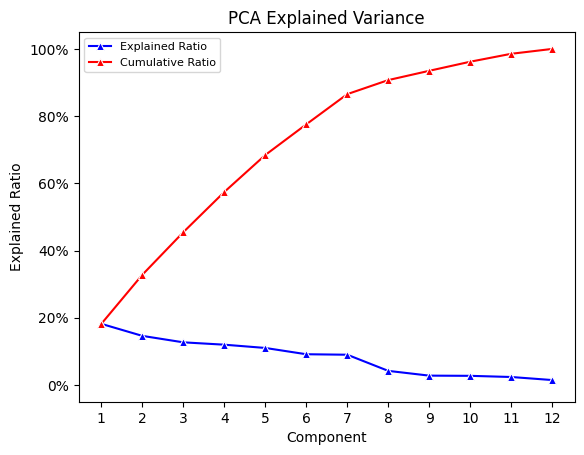

In [ ]:
# visual of PCA Explained Variances

sns.lineplot(pca_df, x='Component', y='Explained Ratio', color='blue', marker='^', label='Explained Ratio')
sns.lineplot(pca_df, x='Component', y='Cumulative Ratio', color='red', marker='^', label='Cumulative Ratio')
plt.legend(fontsize=8)
plt.xticks(pca_df.Component)
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f'{t*100:.0f}%' for t in plt.gca().get_yticks()])
plt.ylim(bottom=-.05, top=1.05)
plt.title('PCA Explained Variance')
plt.show()

## Logistic Regression

### KFold Cross Validation with all independent variables


        Fold 1:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 80.0000%
  

        Fold 2:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 83.3333%
  

        Fold 3:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 76.6667%
  

        Fold 4:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 90.0000%
  

        Fold 5:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 91.6667%
  
Average accuracy score: 84.33% (+/- 5.7349%)


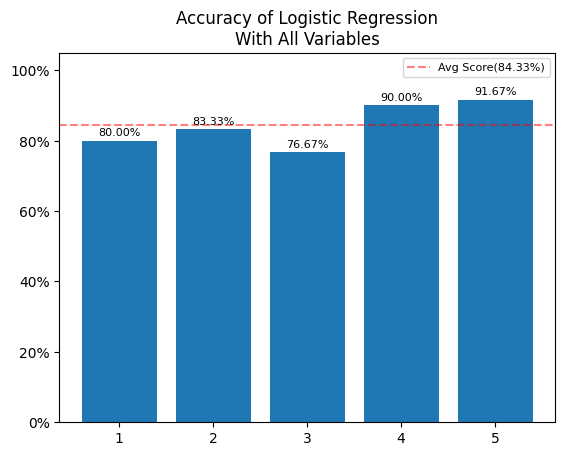

In [ ]:
# KFold Cross Validation

x = x_smote
y = y_smote

n_splits = 5
cv_scores = dict().fromkeys(np.arange(1, n_splits + 1))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for k, (train_index, test_index) in enumerate(kf.split(x, y), 1):
  x_train_cv, x_test_cv = x.iloc[train_index], x.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

  model = LogisticRegression(max_iter=42)
  log_reg = model.fit(x_train_cv, y_train_cv)

  y_pred = log_reg.predict(x_test_cv)
  acc = accuracy_score(y_test_cv, y_pred)
  cv_scores[k] = acc

  print(f'''
        Fold {k}:
        Training set: {len(train_index)} samples
        Test set: {len(test_index)} samples
        Accuracy score: {acc * 100:.4f}%
  ''')

scores = np.array(list(cv_scores.values()))
avg_score = scores.mean()
std_score = scores.std()

print(f'Average accuracy score: {avg_score * 100:.2f}% (+/- {std_score * 100:.4f}%)')

plt.bar(cv_scores.keys(), cv_scores.values())
y_ticks = [f'{x * 100:.0f}%' for x in plt.gca().get_yticks()]
plt.yticks(plt.gca().get_yticks(), y_ticks)
plt.bar_label(plt.gca().containers[0], [f'{x * 100:.2f}%' for x in cv_scores.values()], fontsize=8, padding=2)
plt.title('Accuracy of Logistic Regression\nWith All Variables')

plt.axhline(y=avg_score, xmin=plt.gca().get_xticks()[0],
            xmax = plt.gca().get_xticks()[-1], linestyle='--', color='red',
            alpha=.5, label=f'Avg Score({avg_score * 100:.2f}%)')
plt.legend(title='', fontsize=8)
plt.ylim(top=1.05)
plt.show()

### KFold Cross Validation without platelets & cr. pho.

KFold Cross Validation excluding:
creatinine_phosphokinase
platelets



        Fold 1:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 80.0000%
  

        Fold 2:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 83.3333%
  

        Fold 3:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 80.0000%
  

        Fold 4:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 90.0000%
  

        Fold 5:
        Training set: 240 samples
        Test set: 60 samples
        Accuracy score: 91.6667%
  
Average accuracy score: 85.00% (+/- 4.9441%)


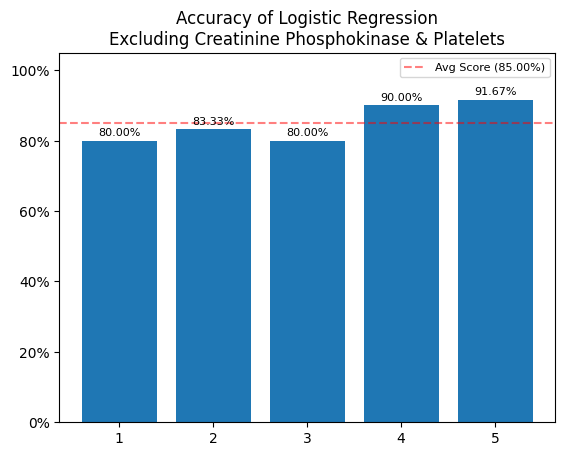

In [ ]:
# KFold Cross Validation without CREATININE_PHOSPHOKINASE and PLATELETS

print('KFold Cross Validation excluding:\ncreatinine_phosphokinase\nplatelets\n\n')

x_2 = x_smote.drop(labels=['creatinine_phosphokinase','platelets'], axis=1)
y = y_smote

n_splits = 5
cv_scores = dict().fromkeys(np.arange(1, n_splits + 1))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for k, (train_index, test_index) in enumerate(kf.split(x_2, y), 1):
  x_train_cv, x_test_cv = x_2.iloc[train_index], x_2.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

  model = LogisticRegression(max_iter=42)
  log_reg = model.fit(x_train_cv, y_train_cv)

  y_pred = log_reg.predict(x_test_cv)
  acc = accuracy_score(y_test_cv, y_pred)
  cv_scores[k] = acc

  print(f'''
        Fold {k}:
        Training set: {len(train_index)} samples
        Test set: {len(test_index)} samples
        Accuracy score: {acc * 100:.4f}%
  ''')

scores = np.array(list(cv_scores.values()))
avg_score = scores.mean()
std_score = scores.std()

print(f'Average accuracy score: {avg_score * 100:.2f}% (+/- {std_score * 100:.4f}%)')

plt.bar(cv_scores.keys(), cv_scores.values())
y_ticks = [f'{x * 100:.0f}%' for x in plt.gca().get_yticks()]
plt.yticks(plt.gca().get_yticks(), y_ticks)
plt.bar_label(plt.gca().containers[0], [f'{x * 100:.2f}%' for x in cv_scores.values()], fontsize=8, padding=2)
plt.title('Accuracy of Logistic Regression\nExcluding Creatinine Phosphokinase & Platelets')

plt.axhline(y=avg_score, xmin=plt.gca().get_xticks()[0],
            xmax = plt.gca().get_xticks()[-1], linestyle='--', color='red',
            alpha=.5, label=f'Avg Score ({avg_score * 100:.2f}%)')
plt.legend(title='', fontsize=8)
plt.ylim(top=1.05)
plt.show()

Based on the KFold CV of the two models, dropping creatinine_phosphokinase and platelets improves the accuracy slightly and creates a slightly smaller standard deviation.

We will remove these two variables from the model ('x_2' df excludes them).

### Training & Testing

In [ ]:
# retraining and testing on full original dataset

model = LogisticRegression(max_iter=1000)

log = model.fit(x_train_cv, y_train_cv)

y_pred = log.predict(x_test.drop(labels=['creatinine_phosphokinase', 'platelets'], axis=1))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score on original dataset: {accuracy*100:.2f}%')
print(f'Classification Report: \n\n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

Accuracy score on original dataset: 80.00%
Classification Report: 

              precision    recall  f1-score   support

           0       0.79      0.91      0.84        53
           1       0.83      0.65      0.73        37

    accuracy                           0.80        90
   macro avg       0.81      0.78      0.78        90
weighted avg       0.80      0.80      0.79        90

          Predicted 0  Predicted 1
Actual 0           48            5
Actual 1           13           24


## Random Forest

### Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators' : np.arange(50, 110, 5),
    'max_features' : [None, 'sqrt', 'log2'],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'bootstrap' : [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search = grid_search.fit(x_smote, y_smote)

print('Below are the best parameters:')
for key, value in grid_search.best_params_.items():
  print(f'{key} : {value}')
print(f'\nBest Accuracy Score: {grid_search.best_score_ * 100:.2f}%')

Below are the best parameters:
bootstrap : True
max_depth : 20
max_features : sqrt
n_estimators : 65

Best Accuracy Score: 94.00%


### Training & Testing

In [ ]:
best_params_rf = grid_search.best_params_
model = RandomForestClassifier(**best_params_rf)
rf = model.fit(x_smote, y_smote)

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Random Forest Accuracy: {accuracy * 100:.2f}%')
print(f'Random Forest Classification Report:\n{classification_report(y_test, y_pred)}%')

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

Random Forest Accuracy: 78.89%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        53
           1       0.85      0.59      0.70        37

    accuracy                           0.79        90
   macro avg       0.81      0.76      0.77        90
weighted avg       0.80      0.79      0.78        90
%
          Predicted 0  Predicted 1
Actual 0           49            4
Actual 1           15           22


## XGBoost

### Hyperparameter Tuning

In [ ]:
param_grid= {
    'max_depth' : np.arange(0, 11, 1),
    'subsample' : np.arange(.4, 1, .1),
    'colsample_bytree' : np.arange(.1, 1.1, .1),
    'learning_rate' : [.1, .01, .001],
    'n_estimators' : [10, 30, 50]
}

grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search = grid_search.fit(x_smote, y_smote)

print('Below are the best paramters:')
for key, value in grid_search.best_params_.items():
  print(f'{key} : {value}')
print(f'\nBest Accuracy Score: {grid_search.best_score_ * 100:.2f}%')

Below are the best paramters:
colsample_bytree : 0.6
learning_rate : 0.1
max_depth : 5
n_estimators : 30
subsample : 0.8999999999999999

Best Accuracy Score: 93.33%


### Training & Testing

In [ ]:
best_params_xgb = grid_search.best_params_
model = xgb.XGBClassifier(**best_params_xgb)
xg = model.fit(x_smote, y_smote)

y_pred = xg.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Classifier Accuracy: {accuracy * 100:.2f}%')
print(f'XGBoost Classification Report:\n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

XGBoost Classifier Accuracy: 78.89%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        53
           1       0.80      0.65      0.72        37

    accuracy                           0.79        90
   macro avg       0.79      0.77      0.77        90
weighted avg       0.79      0.79      0.78        90

          Predicted 0  Predicted 1
Actual 0           47            6
Actual 1           13           24


## Conclusions

The machine learning pipeline started with cleaning and pre-processing. The data was relatively clean. The only pre-processing needed was scaling the continuous variables. After reviewing outliers, we did not find a sizable amount of significant outliers nor did they appear to be incorrect values. The outliers were left in the dataset.

SMOTE was done to balance the target variable in the training set given it was ~70/30 imbalanced. PCA analysis was then conducted. The Principal Components did not provide sizable "explanation of variances." PCA was not used for dimensionality reduction.

We chose three machine learning algorithms to train and test: Logistic Regression, Random Forest, and XGBoost.

- Logistic Regression was conducted with KFold CV first with all independent variables then without Platelets and Creatinine Phosphokinase. When looking at the Platelets and Creatinine Phosphokinase for death event and no death event, there did not appear to be a difference in values. After KFold CV of both instances, the latter without Platelets and Creatinine Phosphokinase was slightly more accurate. This is what was chosen for training and testing.

- Random Forest and XGBoost both had hyperparameter tuning done to determine the best fitting parameters to achieve the best accuracy score. The resulting parameters achieved ~93% - 94% accuracy in training.

For this data set, we are predicting a death event occuring given the independent variables. While each score is important, it is worth noting that with this data, we are focusing on the precision of the "no death" event. Specifically, we want to ensure that there is not a high degree of false negatives in testing (i.e. predicting no death event when a death event will occur).

Below are the results from our training and testing:

- Logistic Regression without Platelets & Creatinine Phosphokinase:
  - Accuracy 80%
  - Overall Precision 80%
  - No death event precision 79%
    - ~4/5 patients correctly predicted no death event

- Random Forest:
 - Parameters chosen:
    - Bootstrap Samples: True
    - Max Depth of Tree: 20
    - Max Features for Splits: sqrt(n_features)
    - Number of trees in forest: 65
  - Accuracy 79.89%
  - Overall Precision 80%
  - No death event precision 77%
    - ~4/5 patients correctly predicted no death event

- XGBoost:
  - Parameters chosen:
    - colsample_bytree: 0.6
      - Subsample ratio of columns for each tree
    - learning rate: 0.1
      - step size of each iteration to minimize loss function
    - max tree depth: 5
    - n_estimators: 30
    - subsample : .8999
      - sample size of training set before creating trees
  - Accuracy 78.89%
  - Overall Precision 79%
  - No death event precision 78%
    - ~4/5 patients correctly predicted no death event

The results show that each classifier model correctly predicted ~4/5 patients with no death event in the test set. For what the models are working to predict, these measures are likely unsatisfactory.


The accuracy of each model on the test set was ~78% - 80%. When conducted training, the logistic regression trained with ~85% - 90% accuracy while the Random Forest and XGBoost models were more accurate when training at 93%+. The higher accuracy in training with much lower accuracy while testing may be driven by each model overfitting the training sets. This may be driven by the models being overfit when training. More hyperparameter tuning may need to occur to create a more generalized model.

Additionally, SMOTE may have impacted the datasets by introducing more noise into the training data. This could have caused the models to overfit to noise. Adjusting the parameters of the SMOTE method may impact future results as well.